In [ ]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests


# Part 1: Data Management
# Define SQL Schema
conn = sqlite3.connect("cell-counts.db")
conn.execute(f"DROP TABLE IF EXISTS subject_data;")
conn.execute(f"DROP TABLE IF EXISTS sample_data;")
conn.commit()

conn.execute("PRAGMA foreign_keys = ON;")

conn.execute("""CREATE TABLE IF NOT EXISTS 
                subject_data ( 
                              project TEXT,
                              subject TEXT PRIMARY KEY,
                              condition TEXT,
                              age INTEGER,
                              sex TEXT, 
                              treatment TEXT,
                              response TEXT
                           )
""")

conn.execute("""
             CREATE TABLE IF NOT EXISTS 
                sample_data ( subject TEXT,
                              sample TEXT PRIMARY KEY,
                              sample_type  TEXT,
                              time_from_treatment_start INTEGER,
                              b_cell INTEGER,
                              cd8_t_cell INTEGER, 
                              cd4_t_cell INTEGER, 
                              nk_cell INTEGER,
                              monocyte INTEGER,
                              FOREIGN KEY (subject) REFERENCES subject_data(subject)
                           )
""")
conn.commit()
conn.close()


# Segment data into subject-level vs sample-level for loading into schema
cell_count = pd.read_csv('cell-count.csv')
subject_data = cell_count[['project', 'subject', 'condition', 'age', 'sex', 'treatment',
                            'response']] \
                         .drop_duplicates(subset="subject")
sample_data = cell_count[['subject', 'sample', 'sample_type', 'time_from_treatment_start',
                           'b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']]

# Connect to SQLite database and load segmented data
connection = sqlite3.connect('cell-counts.db')
subject_data.to_sql('subject_data', 
                  connection,
                  if_exists = 'append',
                  index=False)

sample_data.to_sql('sample_data',
                   connection,
                   if_exists = 'append',
                   index=False)
connection.commit()
connection.close()

# Grab all loaded data for downstream use and assert they are the appropriate size
conn = sqlite3.connect("cell-counts.db")
subject = pd.read_sql("SELECT * FROM subject_data", conn)
sample = pd.read_sql("SELECT * FROM sample_data", conn)
conn.close()

print(f"Entries in subject_data: {len(subject)}, Entries in sample_data: {len(sample)}")

Entries in subject_data: 3500, Entries in sample_data: 10500


In [39]:
# Part 2: Initial Analysis - Data Overview
# Query sample_data to develop table of relative frequencies
rel_freq = sample.drop(['subject', 'sample_type', 'time_from_treatment_start'], axis=1)\
                 .melt(id_vars = "sample", 
                       var_name="population", 
                       value_name="count") \
                 .assign(total_count=lambda d: d.groupby("sample")["count"].transform("sum"), 
                         percentage=lambda d: 100 * d["count"] / d["total_count"]) \
            [["sample", "total_count", "population", "count", "percentage"]]

# Write in relative frequency data for downstream analysis
conn = sqlite3.connect('cell-counts.db')
conn.execute(f"DROP TABLE IF EXISTS relative_frequencies;")
conn.execute("""
    CREATE TABLE IF NOT EXISTS relative_frequencies (
        sample TEXT,
        total_count INTEGER,
        population TEXT,
        count INTEGER,
        percentage FLOAT,
        FOREIGN KEY (sample) REFERENCES sample_data(sample)
    )
""")

rel_freq.to_sql('relative_frequencies', 
                  conn,
                  if_exists = 'append',
                  index=False)
conn.commit()

conn.close()

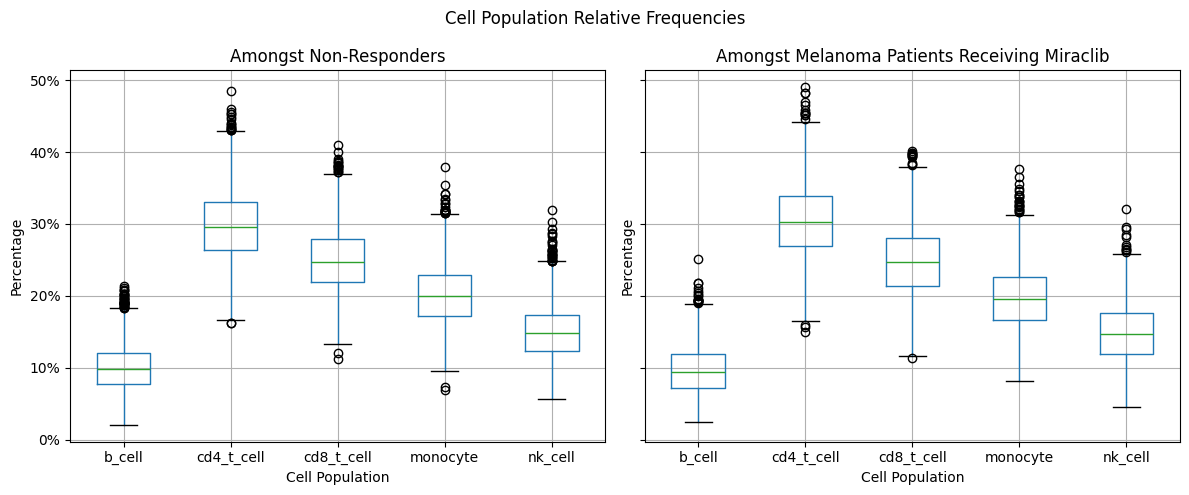

In [75]:
# Part 3: Statistical Analysis
# Select relevant populations from database
conn = sqlite3.connect("cell-counts.db")
melanoma_miraclib = pd.read_sql("""
                                SELECT rf.*
                                FROM relative_frequencies rf
                                JOIN sample_data sd
                                    ON rf.sample = sd.sample
                                INNER JOIN subject_data subj
                                    ON sd.subject = subj.subject
                                WHERE subj.treatment = 'miraclib'
                                AND subj.response = 'yes'
                                AND sd.sample_type = 'PBMC'
                                """, conn)
non_responders = pd.read_sql("""
                                SELECT rf.*
                                FROM relative_frequencies rf
                                JOIN sample_data sd
                                    ON rf.sample = sd.sample
                                INNER JOIN subject_data subj
                                    ON sd.subject = subj.subject
                                WHERE subj.response = 'no'
                                AND sd.sample_type = 'PBMC'
                                """, conn)
conn.close()

# Visualize data from populations in adjacent boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

non_responders.boxplot(column="percentage", by="population", ax=axes[0]) 
axes[0].set_xlabel("Cell Population")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Amongst Non-Responders")
axes[0].yaxis.set_major_formatter(lambda x, _: f"{x:.0f}%")
axes[0].figure.suptitle("")  

melanoma_miraclib.boxplot(column="percentage", by="population", ax=axes[1]) 
axes[1].set_xlabel("Cell Population")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Amongst Melanoma Patients Receiving Miraclib")
axes[1].yaxis.set_major_formatter(lambda x, _: f"{x:.0f}%")
axes[1].figure.suptitle("Cell Population Relative Frequencies")  

plt.tight_layout()
plt.show()

In [ ]:
# 1) Mann–Whitney U (Wilcoxon rank-sum) per population + BH-FDR correction
pops = sorted(set(melanoma_miraclib["population"]).intersection(non_responders["population"]))
rows = []
for pop in pops:
    x = melanoma_miraclib.loc[melanoma_miraclib["population"] == pop, "percentage"].dropna().to_numpy()
    y = non_responders.loc[non_responders["population"] == pop, "percentage"].dropna().to_numpy()

    # Skip if not enough data in either group
    if len(x) < 2 or len(y) < 2:
        rows.append({"population": pop, "n_responders": len(x), "n_nonresponders": len(y),
                     "median_responders": np.median(x) if len(x) else np.nan,
                     "median_nonresponders": np.median(y) if len(y) else np.nan,
                     "U": np.nan, "p": np.nan})
        continue

    U, p = mannwhitneyu(x, y, alternative="two-sided", method="auto")
    rows.append({"population": pop, "n_responders": len(x), "n_nonresponders": len(y),
                 "median_responders": np.median(x), "median_nonresponders": np.median(y),
                 "U": U, "p": p})

results = pd.DataFrame(rows)

# 2) Benjamini–Hochberg FDR (q-values)
mask = results["p"].notna()
results.loc[mask, "q"] = multipletests(results.loc[mask, "p"], method="fdr_bh")[1]
results["significant_q05"] = results["q"] < 0.05

# 3) Add an effect-size-ish summary: median difference (responders - nonresponders)
results["median_diff"] = results["median_responders"] - results["median_nonresponders"]

# 4) Sort: most significant first
results = results.sort_values(["q", "p"], na_position="last").reset_index(drop=True)

# View all results + just significant ones
print(results)
print("\nSignificant at FDR q<0.05:")
print(results.loc[results["significant_q05"], ["population","n_responders","n_nonresponders","median_responders","median_nonresponders","median_diff","U","p","q"]])


   population  n_responders  n_nonresponders  median_responders  \
0  cd4_t_cell          1707             3180          30.306118   
1      b_cell          1707             3180           9.388131   
2    monocyte          1707             3180          19.524250   
3  cd8_t_cell          1707             3180          24.682923   
4     nk_cell          1707             3180          14.701993   

   median_nonresponders          U         p         q  significant_q05  \
0             29.628746  2908988.0  0.000034  0.000171             True   
1              9.761919  2542434.0  0.000261  0.000652             True   
2             19.923107  2599939.0  0.015165  0.025274             True   
3             24.758714  2658234.0  0.234559  0.293198            False   
4             14.771717  2684239.0  0.524995  0.524995            False   

   median_diff  
0     0.677373  
1    -0.373788  
2    -0.398857  
3    -0.075791  
4    -0.069723  

Significant at FDR q<0.05:
   population  n

In [ ]:
# Part 4: Data Subset Analysis
# Select relevant data according to step 1
conn = sqlite3.connect("cell-counts.db")
subset = pd.read_sql("""
                     SELECT subj.*, sd.sample
                     FROM subject_data subj
                     JOIN sample_data sd
                         ON subj.subject = sd.subject
                     WHERE subj.condition = 'melanoma'
                     AND subj.treatment = 'miraclib'
                     AND sd.sample_type = 'PBMC'
                     AND sd.time_from_treatment_start = 0
                     """, conn)
conn.close()

# sanity check using original cell_count dataframe with all data
# cell_count.query("condition == 'melanoma' and \
#                  treatment == 'miraclib' and \
#                  time_from_treatment_start == 0 and \
#                  sample_type == 'PBMC'")['project'].unique()
# len(subset)

# Calculate query extensions listed in step 2
samples_by_project = subset.groupby('project').size()
subject_response = subset.groupby('response').size()
subject_sex = subset.groupby('sex').size()

In [81]:
# Google Form Question
num = cell_count.query("condition == 'melanoma' and \
                        sex == 'M' and \
                        response =='yes' and \
                        time_from_treatment_start == 0")
num['b_cell'].mean()

np.float64(10206.150515463918)